In [1]:
import jupyter_black

jupyter_black.load()

In [65]:
from pathlib import Path
from pyfaidx import Fasta
import pandas as pd
import numpy as np
import h5py


base = Path("../data/dan_review/")
out_base = Path("../data/protspace_after_dan/")
ppihp_base = base / "PPIHP"
# PATH in
csv_path = base / "3FTx_addedNew.csv"
fasta_path = base / "3FTx_resubmission_DSD_v2.fasta"
manual_new = base / "manual_new.fasta"
signalp_new = base / "signalp.fasta"
old_fasta_full_path = "../data/protspace/3FTx_full.fasta"
# PPIHP
embs_prott5_path = ppihp_base / "protein_embeddings.npy"
ids_path = ppihp_base / "ids.txt"
la_mem_path = ppihp_base / "la_mem_pred.txt"


# PATH out
fasta_isoform_out = out_base / "3FTx_isoform_yes.fasta"
fasta_noIsoform_out = out_base / "3FTx_isoform_no.fasta"
h5_prott5_out = out_base / "3FTx_prott5.h5"
csv_out = out_base / "3FTx.csv"
fast_full_out = out_base / "3FTx_full.fasta"

In [66]:
def read_txt_file(txt_file) -> list[str]:
    data = []
    with open(txt_file, "r") as handle_txt:
        for line in handle_txt:
            line = line.strip()
            data.append(line)
    return data

### Save ProtT5 embeddings from .npy to .h5

In [71]:
embs = np.load(embs_prott5_path)
headers = [header.replace(">", "") for header in read_txt_file(ids_path)]

with h5py.File(h5_prott5_out, "w") as handle_hdf:
    for header, emb in zip(headers, embs):
        handle_hdf.create_dataset(header, data=emb)

### Add PPIHP predictions to .csv file

In [68]:
df = pd.read_csv(csv_path)
df = df.drop(columns=["id_new"])
for header, la_mem in zip(headers, read_txt_file(la_mem_path)):
    df.loc[df["identifier"] == header, "pred_membran"] = la_mem
df.to_csv(csv_out, index=False)

### Create FASTA files without "-"

In [69]:
# yes Isoforms
with open(fasta_isoform_out, "w") as fasta_handle:
    for header, seq in Fasta(fasta_path, read_long_names=True).items():
        seq = str(seq).replace("-", "")
        fasta_handle.write(f">{header}\n")
        fasta_handle.write(f"{seq}\n")
    for header, seq in Fasta(signalp_new, read_long_names=True).items():
        fasta_handle.write(f">{header}\n")
        fasta_handle.write(f"{seq}\n")

# No isoforms
with open(fasta_noIsoform_out, "w") as fasta_handle:
    for header, seq in Fasta(fasta_path, read_long_names=True).items():
        seq = str(seq).replace("-", "")
        fasta_handle.write(f">{header}\n")
        fasta_handle.write(f"{seq}\n")

In [70]:
# write full sequences out
with open(fast_full_out, "w") as handle_out:
    for header, seq in Fasta(old_fasta_full_path, read_long_names=True).items():
        header = header.replace(" ", "_")
        if header in df["identifier"].to_list():
            handle_out.write(f">{header}\n")
            handle_out.write(f"{seq}\n")
    for header, seq in Fasta(manual_new, read_long_names=True).items():
        seq = str(seq)
        if seq.startswith("M"):
            handle_out.write(f">{header}\n")
            handle_out.write(f"{seq}\n")

### create clans file
Coloring starts with `<seqgroups>` and ends with `</seqgroups>`. Each group contains name, type, size, hide, color, numbers. e.g:
```
name=network:10;true;false_25
type=0
size=4
hide=0
color=208;53;28;255
numbers=558;563;587;593;598;614;622;626;627;634;
```

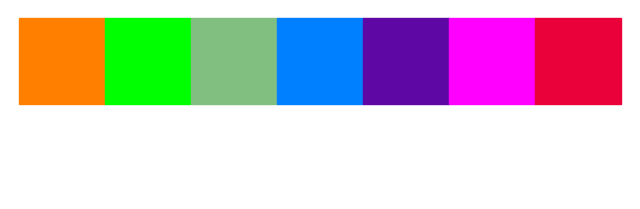

In [132]:
import colorsys
from distinctipy import distinctipy

coloring_col = "cysteine_group"
group_members = df[coloring_col].unique()

# number of colours to generate
N = len(group_members)
seed = 42

# 'Normal', 'Protanopia', 'Protanomaly', 'Deuteranopia', 'Deuteranomaly', 'Tritanopia', 'Tritanomaly', 'Achromatopsia', 'Achromatomaly'
colorblind_type = "Normal"
colors = distinctipy.get_colors(N, colorblind_type=colorblind_type, rng=seed)
colors = [colorsys.rgb_to_hls(*color) for color in colors]
colors = [colorsys.hls_to_rgb(*color) for color in sorted(colors[:N])]

# display the colours
distinctipy.color_swatch(colors)
colors = [list(map(lambda x: int(x * 255), color)) + [255] for color in colors]

In [128]:
clans_in_path = Path("../data/clans/10K_run.txt")
clans_out_path = Path("../data/clans/10K_run_color.txt")

data = []
dot_size = 7
with open(clans_in_path, "r") as handle_in, open(clans_out_path, "w") as handle_out:
    seq_part = False
    for line in handle_in:
        # --- read data ---
        if line.startswith("<seq>"):
            seq_part = True
        elif line.startswith("</seq>"):
            seq_part = False

        if line.startswith(">") and seq_part:
            header = line.strip()[1:]
            data.append(header)

        # --- write data ---
        handle_out.write(line)
        if line.startswith("</seq>"):
            # write colors
            handle_out.write("<seqgroups>\n")
            df_group = df.groupby(coloring_col)["identifier"].apply(lambda x: list(x))
            for (groupname, headers), color in zip(df_group.items(), colors):
                print(groupname)
                indices = []
                for header in headers:
                    idx = data.index(header)
                    indices.append(idx)
                handle_out.write(f"name={groupname}\n")
                handle_out.write("type=0\n")
                handle_out.write(f"size={dot_size}\n")
                handle_out.write("hide=0\n")
                handle_out.write(f"color={';'.join(map(str, color))}\n")
                handle_out.write(f"numbers={';'.join(map(str, indices))}\n")
            handle_out.write("</seqgroups>\n")

Long-chain
Ly-6
Non-standard
Plesiotypic
Short-chain
pre-3FTx
